In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_dir = "/content/drive/MyDrive/"
import os
os.chdir(root_dir + 'Brain_Tumor')

****************
2870
2870
(2870, 150, 150, 3)
(2870,)

Training Set
(2296, 150, 150, 3)
(2296,)

Testing Set
(574, 150, 150, 3)
(574,)
x_train shape after :  (2296, 1, 150, 150, 3)
x_test shape after :  (574, 1, 150, 150, 3)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 1, 148, 148, 64)  1792      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 1, 74, 74, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 1, 72, 72, 32)    18464     
 stributed)                                                      
                                                                 
 time_distributed_18 (Time

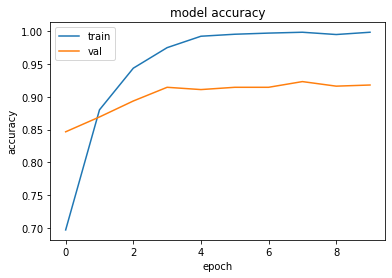

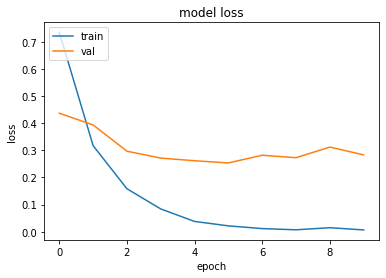

18/18 [==============================] - 2s 24ms/step


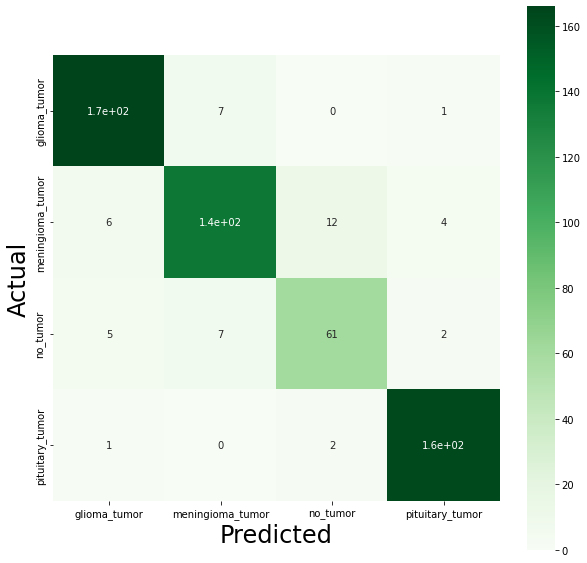

In [7]:
#importing necessary libraries
import pandas as pd
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import SGD
import itertools
import tensorflow as tf
import numpy as np
import os
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalMaxPooling2D,GlobalAveragePooling2D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

#define dataset path
data_path="Project_Dataset/Training"

my_list=os.listdir(data_path)
print(my_list)
print(len(my_list))


#perform denoising
def denoise(image):

    #denoising using Non-local mean algorithm
    out = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
    return out

#initialize variables
data=[]
labels=[]
img_size=150

for i in my_list:
    image_list=os.listdir(data_path+"/"+i)
    for j in image_list:
        # try:
        path=data_path+"/"+i+"/"+j
        #read image
        img=cv2.imread(path)
        #perform image resizing
        img=cv2.resize(img,(img_size,img_size))
        #denoising
        output=denoise(img)

        img_yuv = cv2.cvtColor(output,cv2.COLOR_BGR2YUV)

        # apply histogram equalization 
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        data.append(hist_eq)
        print("i : ",i)
        if i=="glioma_tumor":
            labels.append(0)
        elif i=="meningioma_tumor":
            labels.append(1)
        elif i=="no_tumor":
            labels.append(2)
        else:
            labels.append(3)


print(len(data))
print(len(labels))


#saving as pickle file
pickle.dump(data,open('data.pkl','wb'))
pickle.dump(labels,open('labels.pkl','wb'))


##########################

#loading pickle files
data=pickle.load(open('data.pkl','rb'))
labels=pickle.load(open('labels.pkl','rb'))
print("****************")
print(len(data))
print(len(labels))

data=np.array(data)
labels=np.array(labels) 

print(data.shape)
print(labels.shape)


from sklearn.model_selection import train_test_split
#perform train-test splitting
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=0, shuffle=True,test_size=0.2)
print("\nTraining Set")
print(x_train.shape)
print(y_train.shape)
print("\nTesting Set")
print(x_test.shape)
print(y_test.shape)

x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
print("x_train shape after : ",x_train.shape)
print("x_test shape after : ",x_test.shape)

x_train=x_train/255
x_test=x_test/255



#perform Label encoding (return binary)
from sklearn.preprocessing import LabelBinarizer
#initialize
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)
y_test = label_as_binary.fit_transform(y_test)


from model import CNN_RNN

#function call
model=CNN_RNN()

#compiling the mode;
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])

#saving the model
checkpoint=ModelCheckpoint("Project_Saved_Models/brain_tumor_model.h5",
                           monitor="val_acc",
                           save_best_only=True,
                           verbose=1)

#training
history= model.fit(x_train,y_train,epochs=10,batch_size=4,validation_data=(x_test,y_test),callbacks=[checkpoint])

#plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Project_Extra/acc_final.png")
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Project_Extra/loss_final.png")
plt.show()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


disease_types=['glioma_tumor', 'meningioma_tumor','no_tumor','pituitary_tumor']
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=24)
ax.set_xlabel('Predicted', fontsize=24)
plt.show()


